In [20]:

from transformers import ViltProcessor, ViltForQuestionAnswering
from PIL import Image
import matplotlib.pyplot as plt
import os
import re
import torch
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import inflect
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from bert_score import score as bert_score


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Importing the ViltProcessor class for processing inputs for the VILT model
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

# Loading the VILT model for Visual Question Answering, fine-tuned for VQA, and moving it to the specified device
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa").to(device)

In [ ]:
# creating an instance of the inflect engine for manipulating text (e.g., converting numbers to words)
inflect_engine = inflect.engine()

In [ ]:
# normalizing text-based answers
def normalize_answer(ans):
    # checking if the input is a string
    if not isinstance(ans, str): 
        return ""  
    
    # converting to lowercase and removing leading/trailing whitespace
    ans = ans.strip().lower()
    ans = re.sub(r'[^\w\s]', '', ans)  
    # converting numeric answers to words
    if ans.isdigit():
        ans = inflect_engine.number_to_words(ans)
    # splitting the answer into words and returning the first word or an empty string
    words = ans.split()
    return words[0] if words else ""  


In [ ]:
#image path
def preprocess_csv(csv_path, base_folder="./"):
    df = pd.read_csv(csv_path)

    # updating the 'full_image_path' column with absolute paths
    df['full_image_path'] = df['full_image_path'].apply(
        lambda x: os.path.join(base_folder, x.replace('\\', '/'))
    )

    # identifying missing files
    missing = df[~df['full_image_path'].apply(os.path.exists)]
    if not missing.empty:
        print("miss")

    # filtering to retain rows with valid file paths
    df = df[df['full_image_path'].apply(os.path.exists)]
    return df

In [26]:
train_df = preprocess_csv("train_split.csv", base_folder="./")


In [27]:
train_df

,image_id,full_image_path,question,answer
0,61O3OvMdUOL,./abo-images-small/images/small/99/99ce17a6.jpg,What is at top?,Lens
1,71arbUP95DL,./abo-images-small/images/small/63/637c739a.jpg,What color is the background?,Yellow
2,61p0vAUBhnL,./abo-images-small/images/small/11/1191deb3.jpg,What is the main color?,Multi-colored
3,717OaAOu6+L,./abo-images-small/images/small/35/3542cd51.jpg,Are more flowers partially visible or fully vi...,Partially
4,71c5z9x15CL,./abo-images-small/images/small/bb/bb0a0222.jpg,What color is the parrot's chest?,Yellow
...,...,...,...,...
29695,711KHYj5dUL,./abo-images-small/images/small/86/86144122.jpg,Is it portrait or landscape?,Portrait
29696,71kLHB+I3LL,./abo-images-small/images/small/3a/3a7869ec.jpg,What shape is prominent?,Oval
29697,81yC9R01CuL,./abo-images-small/images/small/a6/a60bdead.jpg,What animal is pictured?,Tiger
29698,81oo9onNt+L,./abo-images-small/images/small/aa/aafc5aff.jpg,What color is the heel tag?,Rosegold


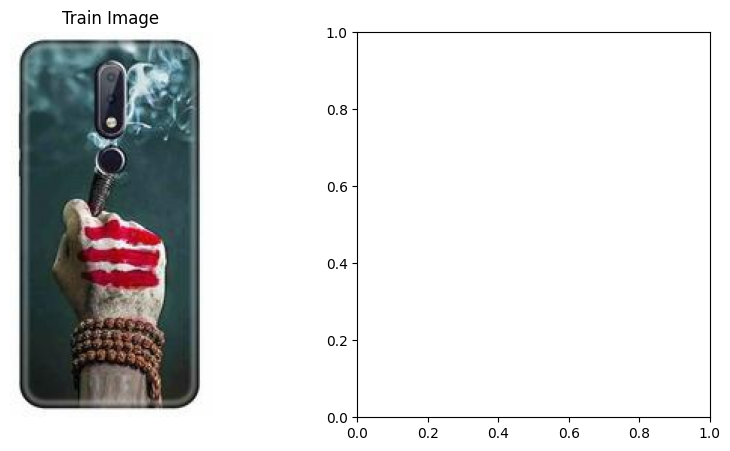

In [ ]:
train_df['normalized_answer'] = train_df['answer'].astype(str).str.strip().str.lower()

# Sample image to test path
train_image_path = train_df.iloc[0]['full_image_path']
train_image = Image.open(train_image_path).convert("RGB")


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display train image
axes[0].imshow(train_image)
axes[0].axis('off')
axes[0].set_title('Train Image')



plt.show()


In [ ]:
# evaluating the model on a given dataset split
def evaluate(df, split_name="Split"):
    # printing the current split being evaluated
    print(f"\n Evaluating split: {split_name}")
    
    all_preds = []  # storing all predicted answers
    all_labels = []  # storing all actual answers

    # iterating over each row in the dataframe with a progress bar
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Running ViLT on {split_name}"):
        # opening the image and converting to RGB
        try:
            image = Image.open(row['full_image_path']).convert("RGB")
        except:
            continue  # skipping if image fails to open

        question = row['question']  # extracting the question
        
        # skipping rows without an answer
        if pd.isna(row['answer']) or row['answer'] is None:
            continue  
        
        # normalizing the actual answer text
        actual_answer = normalize_answer(row['answer'])

        # processing inputs and running the model to get predictions
        try:
            inputs = processor(image, question, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model(**inputs)
                pred_id = outputs.logits.argmax(-1).item()
                pred_raw = model.config.id2label[pred_id].lower()
                pred = normalize_answer(pred_raw)
        except:
            continue  # skipping if prediction fails

        all_preds.append(pred)  # appending predicted answer
        all_labels.append(actual_answer)  # appending actual answer

    # computing accuracy metric
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\n Accuracy on {split_name}: {accuracy * 100:.2f}%")

    # computing BERTScore metrics for more nuanced evaluation
    P, R, F1 = bert_score(all_preds, all_labels, lang="en", verbose=True)
    print(f" BERTScore - Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

    # printing classification report with precision, recall, f1 for each class
    print("\n Classification Report:")
    print(classification_report(all_labels, all_preds, zero_division=0))

    # returning evaluation metrics and predictions
    return {
        "accuracy": accuracy,
        "bertscore": {"precision": P.mean().item(), "recall": R.mean().item(), "f1": F1.mean().item()},
        "predictions": all_preds,
        "labels": all_labels
    }


In [33]:
train_metrics = evaluate(train_df, "Train")

print("\n Train Evaluation Metrics:")
print(train_metrics)



 Evaluating split: Train


Running ViLT on Train: 100%|████████████| 29700/29700 [1:14:50<00:00,  6.61it/s]



 Accuracy on Train: 26.11%


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/27 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/464 [00:00<?, ?it/s]

done in 17.01 seconds, 1744.22 sentences/sec
 BERTScore - Precision: 0.9811, Recall: 0.9759, F1: 0.9781

 Classification Report:
                  precision    recall  f1-score   support

             10k       0.00      0.00      0.00         1
             14k       0.00      0.00      0.00         2
           14klg       0.00      0.00      0.00         1
               3       0.00      0.00      0.00         0
              3d       0.00      0.00      0.00         2
               4       0.00      0.00      0.00         0
               a       0.00      0.00      0.00        16
             a3s       0.00      0.00      0.00         1
             a71       0.00      0.00      0.00         1
          aayega       0.00      0.00      0.00         2
           above       0.52      0.77      0.62       513
          absent       0.00      0.00      0.00         1
        abstract       0.25      0.03      0.05        65
       accessory       0.00      0.00      0.00         1
